# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


In [138]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [139]:
df = pd.read_csv('data_BCN.csv')

In [140]:
df.head()

,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


# EDA

In [141]:
fig = px.line(df, x='time', y='orders')
# Display the figure
fig.show()

+ i see overall increasing trend (though the direction changes in 2022);
+ there are some cicles (for instance, in summer 2021);
+ definitely very vivid seasonality (hourly, mostly);
+ pikes from 18pm till 21 pm, also lesser pikes from 12 pm till 16 pm

In [142]:
df.head()

,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8766 non-null   object 
 1   orders  8766 non-null   float64
 2   city    8766 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.6+ KB


In [144]:
df.describe()

,orders
count,8766.000000
mean,73.145175
std,111.038384
min,0.000000
25%,0.000000
50%,30.000000
75%,97.000000
max,939.000000


In [145]:
TARGET = 'orders'

In [146]:
df[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8766.0,73.15,111.04,0.0,0.0,30.0,97.0,939.0


array([[<AxesSubplot: title={'center': 'orders'}>]], dtype=object)

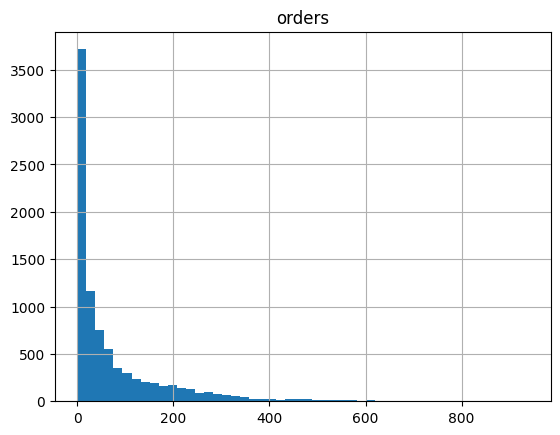

In [147]:
df[[TARGET]].hist(bins=50)

+ we see lots of null 'orders' (basically time, when nobody orders);
+ distribution is skewed;
+ there are outliers on the right side (that max - 939)

In [148]:
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)  # Ensure index is in datetime format

In [149]:
df.index.min(), df.index.max()

(Timestamp('2021-02-01 00:00:00'), Timestamp('2022-02-01 23:00:00'))

C:\Users\Asus\AppData\Local\Temp\ipykernel_35372\3634819214.py:3: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\Asus\AppData\Local\Temp\ipykernel_35372\3634819214.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Asus\AppData\Local\Temp\ipykernel_35372\3634819214.py:3: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



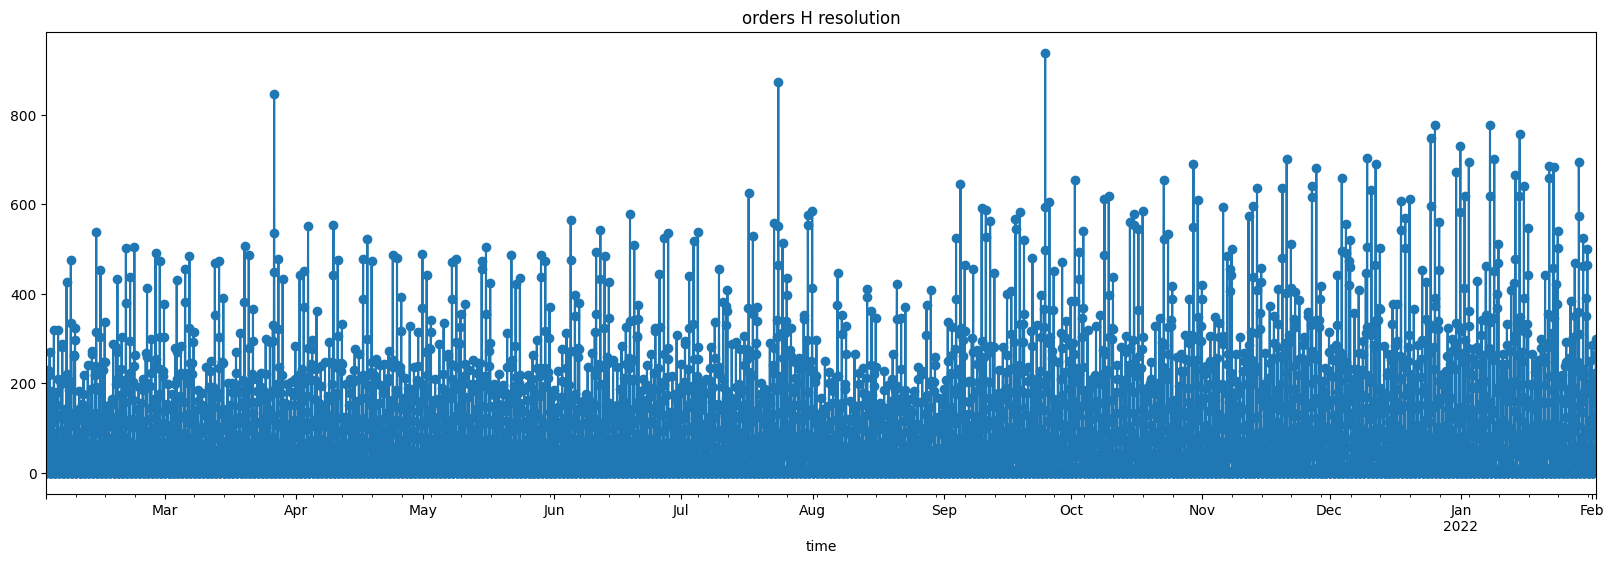

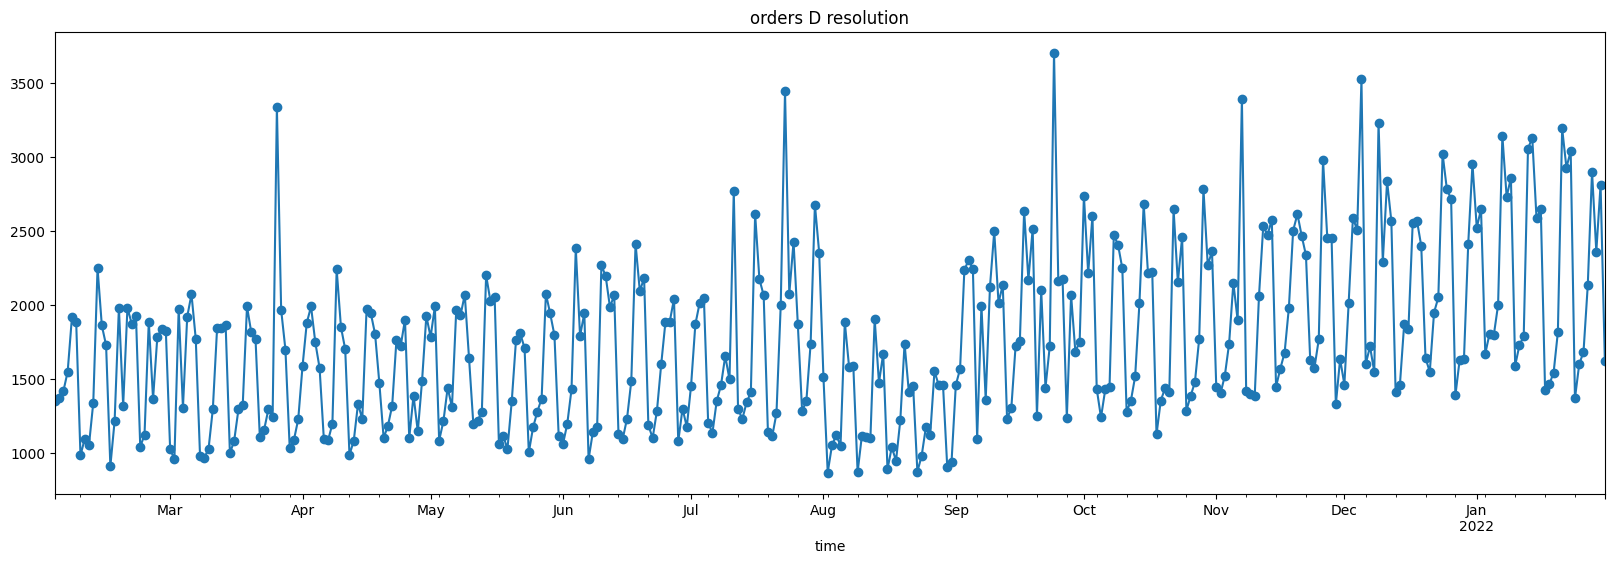

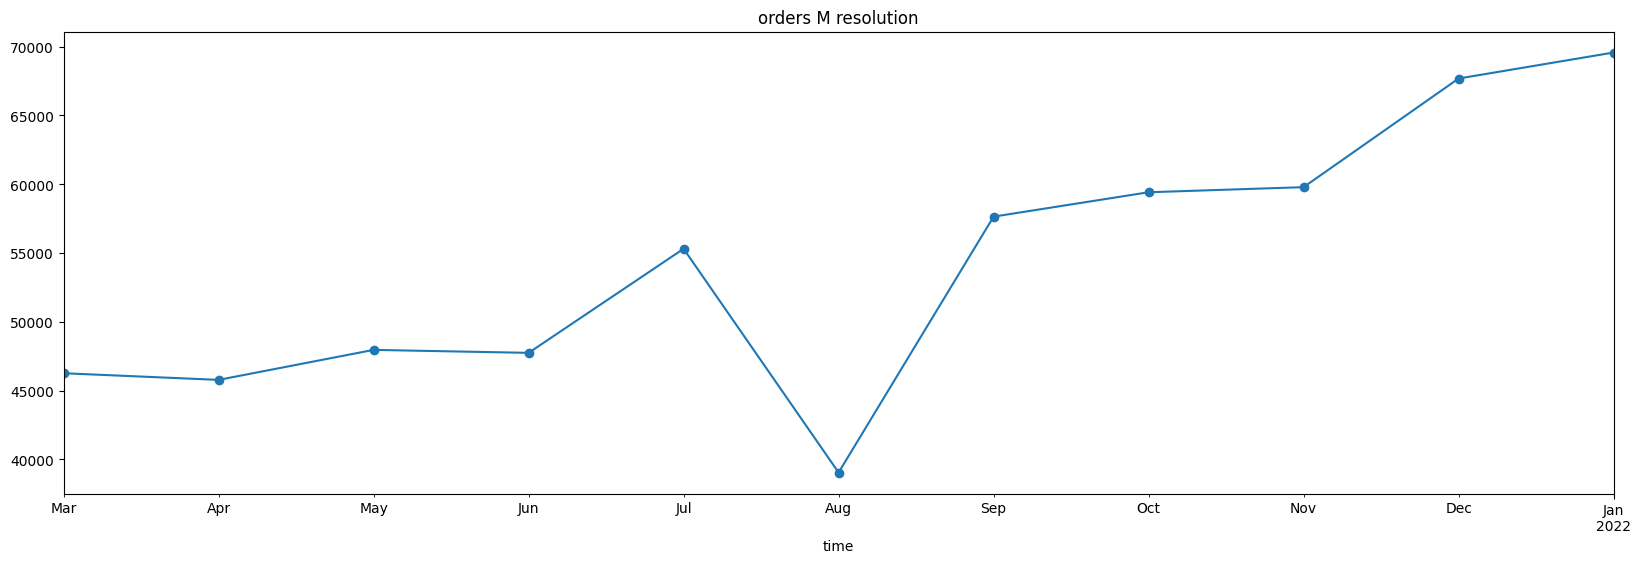

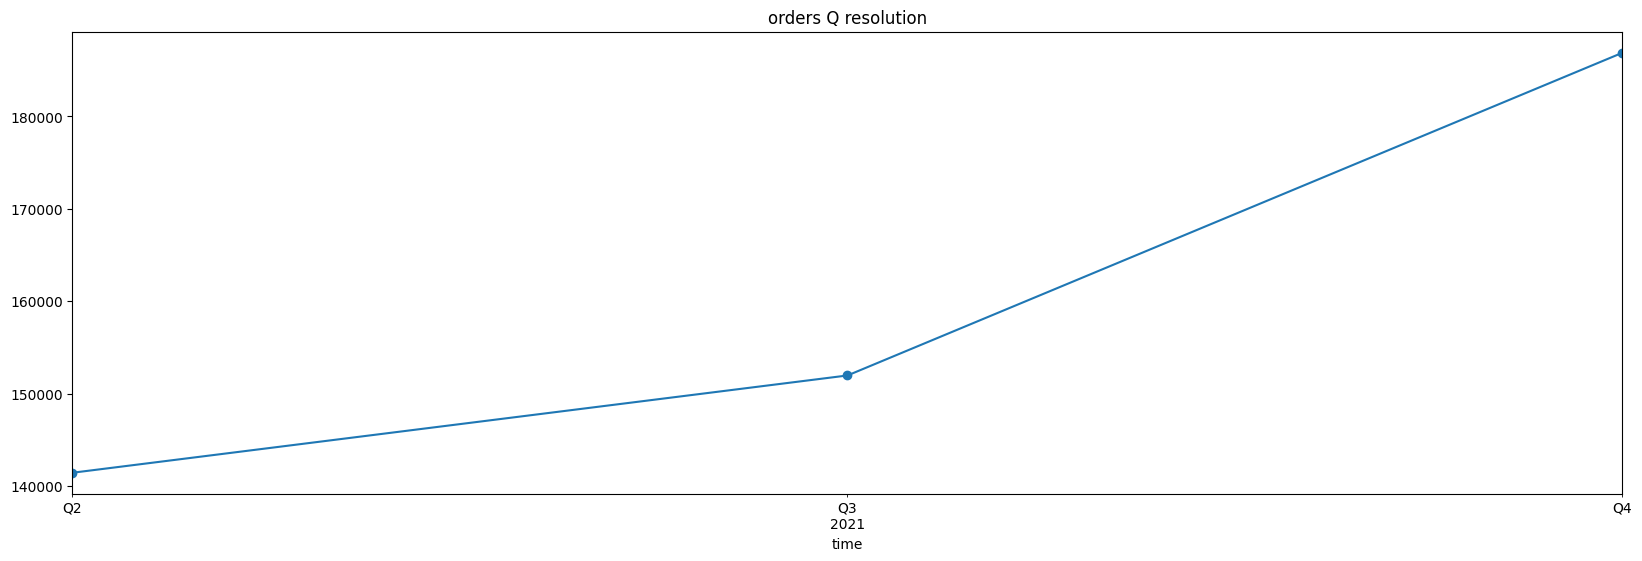

In [150]:
for resolution in ['H', 'D', 'M', 'Q']:
    fig, ax = plt.subplots(figsize=(20, 6))
    df['orders'].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'orders {resolution} resolution')

+ we see overall trend from month to month (most evident quarterly);
+ there is drop in August (seems because nobody works in Bcn in august so there is nothing to deliver);
+ seasonal changes by hour are most clear

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Asus\anaconda3\envs\new_env\lib\s

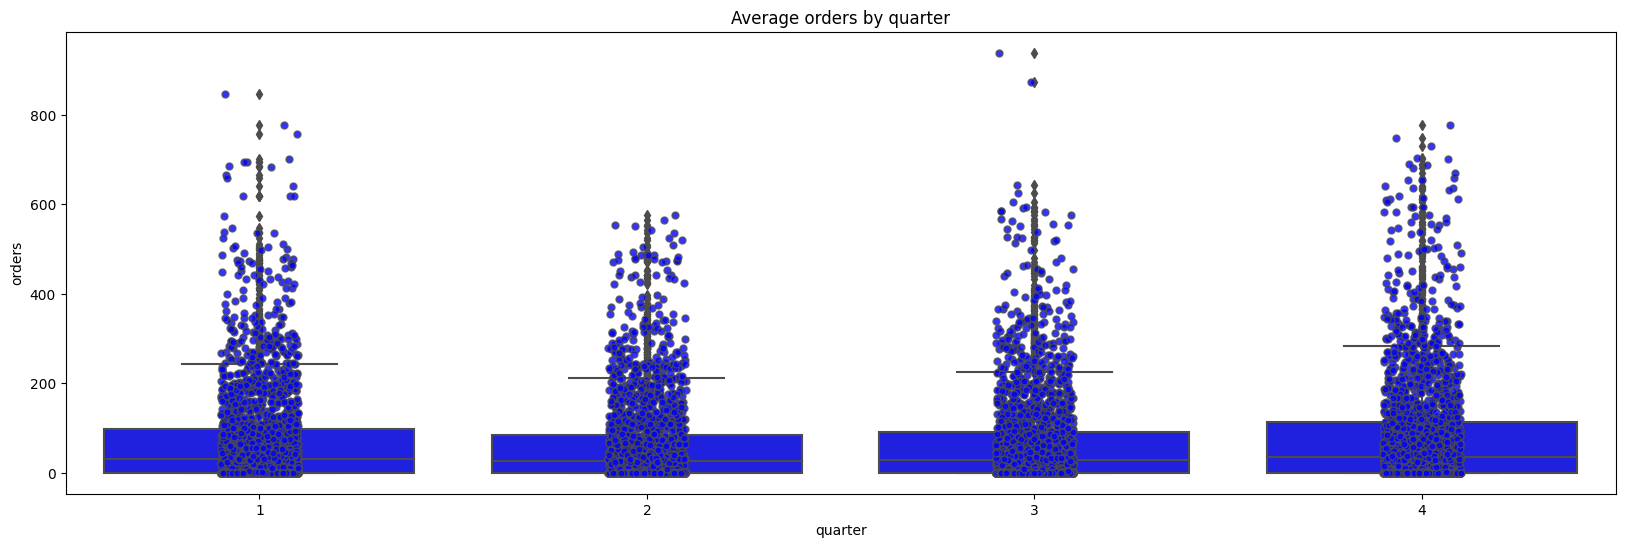

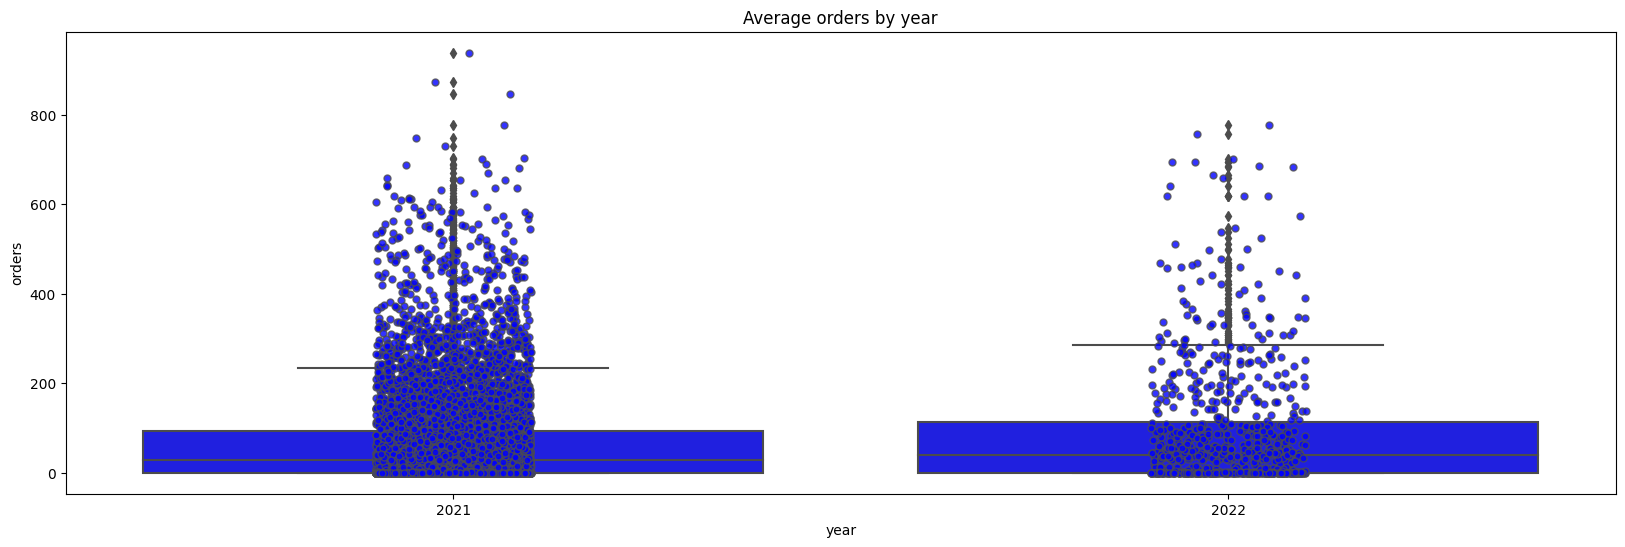

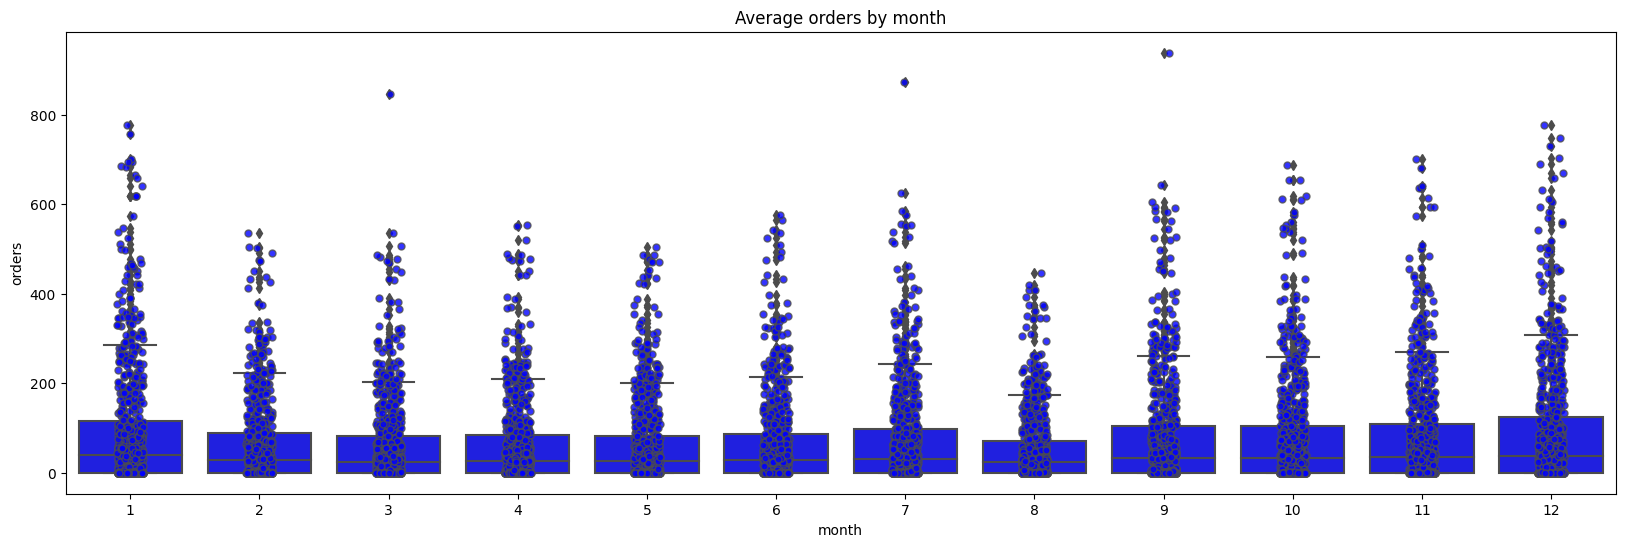

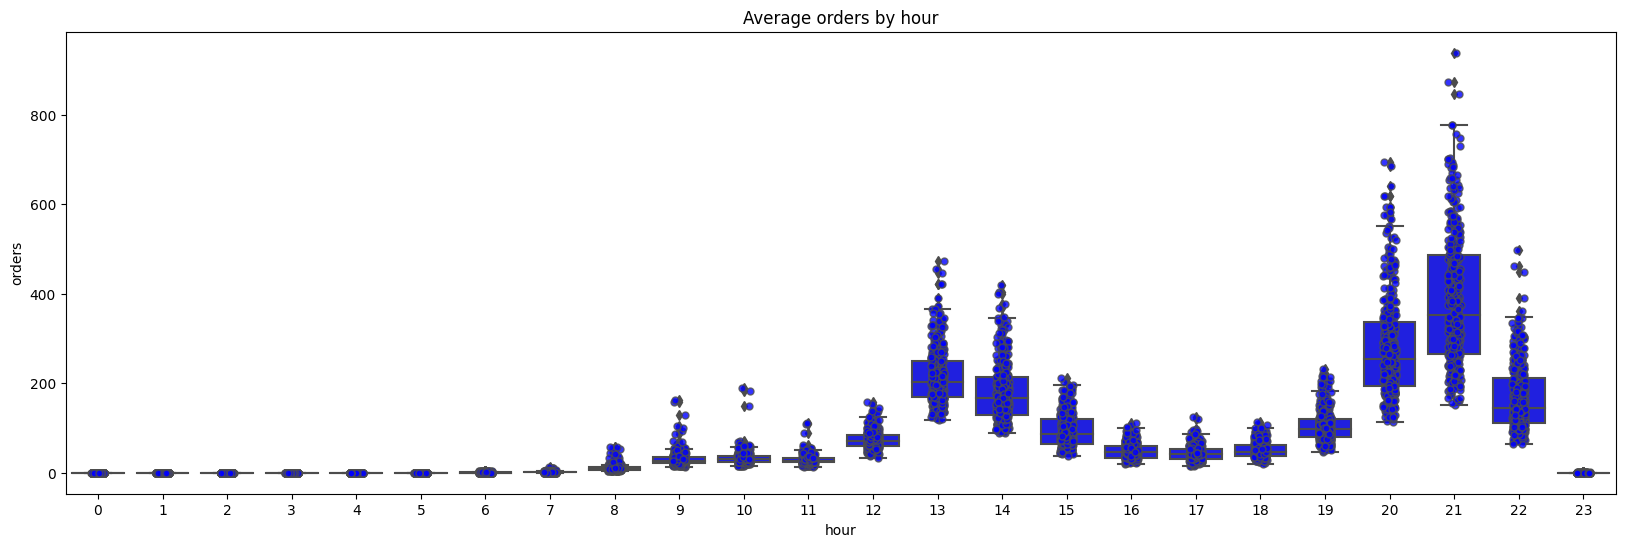

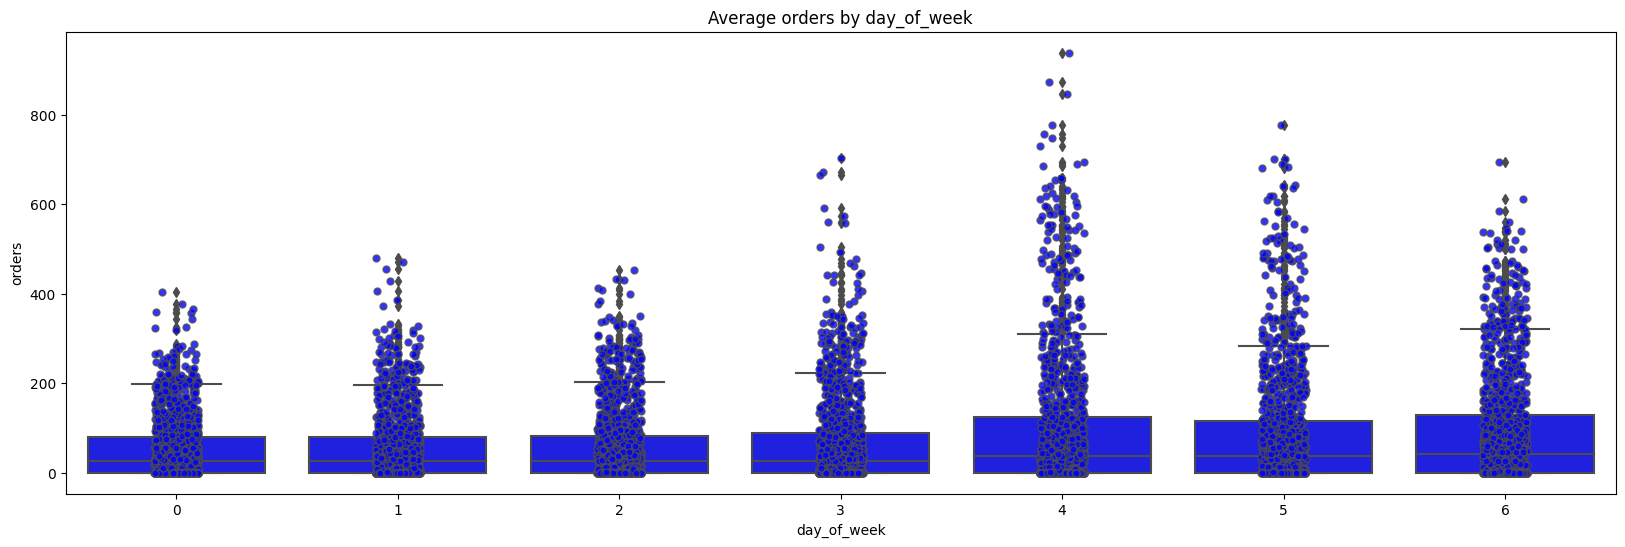

In [151]:
# Extract time features
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

# List of time features
time_features = [
    'quarter',
    'year',
    'month',
    'hour',
    'day_of_week'
]

# Plotting
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x=f_name, y="orders", data=df, ax=ax, color='b')
    sns.stripplot(data=df, x=f_name, y='orders', ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Average orders by {f_name}')

seasonality is most vivid in terms of hours and days of the week

-0.0


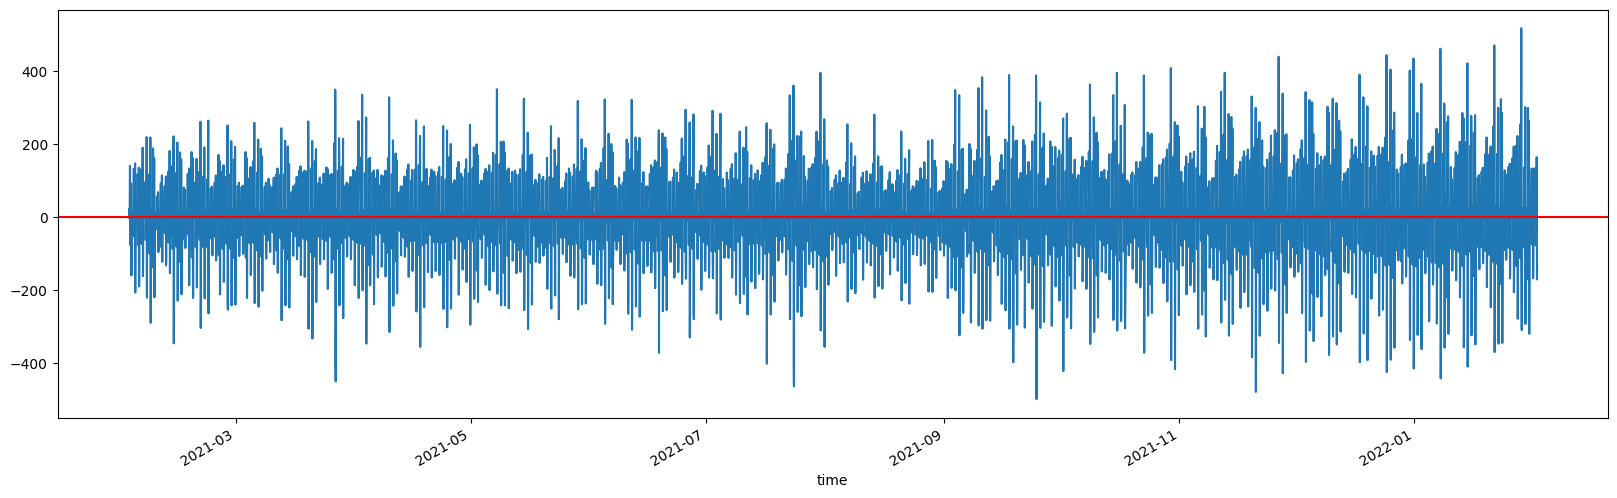

In [152]:
fig, ax = plt.subplots(figsize=(20, 6))
ax = df['orders'].diff().plot(ax=ax)
print(df['orders'].diff().mean().round(3))
ax.axhline(df['orders'].diff().mean(), color='red')

Plot shows the difference in orders over time and adds a horizontal line indicating the mean difference in orders.

WHat can be done:
+ remove outliers (some weirdly huge outliers + august);
+ log transformation

# Split

In [153]:
df.index.min(), df.index.max()

(Timestamp('2021-02-01 00:00:00'), Timestamp('2022-02-01 23:00:00'))

In [154]:
train_df = df.iloc[:-168]  # Train on all data except the last week
test_df = df.iloc[-168:]  # Test on the last week

# Outliers

In [155]:
# from scipy.stats.mstats import winsorize
# # Winsorize the 'orders' column at 5% and 95% thresholds
# train_df['orders'] = winsorize(train_df['orders'], limits=(0.05, 0.05))

# Circle

In [156]:
import pandas as pd

# Calculate the mean of 'orders_winsorized' for every hour, excluding data for month=8
mean_hourly_data = train_df[train_df['month'] != 8].groupby('hour')['orders'].mean()

# Replace hourly data for month=8 with mean hourly values
train_df.loc[df['month'] == 8, 'orders'] = train_df[train_df['month'] == 8].apply(
    lambda row: mean_hourly_data[row['hour']], axis=1
)

# Add back the rows with month=8 to the DataFrame
train_df = pd.concat([train_df[train_df['month'] != 8], train_df[train_df['month'] == 8]])

# Sort the DataFrame back to its original order
train_df = train_df.sort_index()

# Tests

<Figure size 1200x600 with 0 Axes>

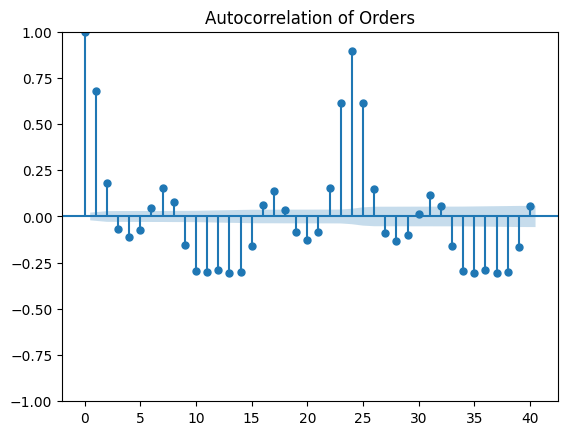

<Figure size 1200x600 with 0 Axes>

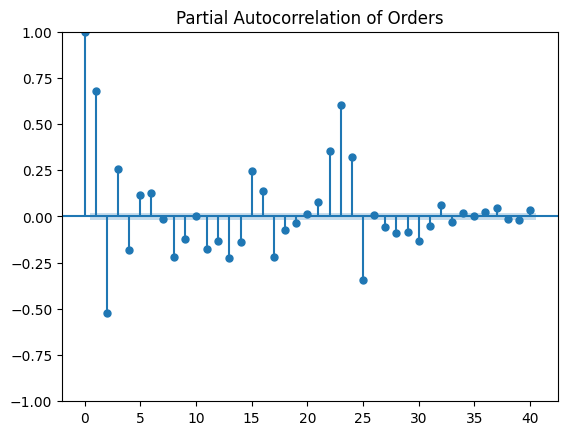

In [157]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['orders'].dropna(), lags=40, alpha=0.05, title='Autocorrelation of Orders')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['orders'].dropna(), lags=40, alpha=0.05, title='Partial Autocorrelation of Orders')
plt.show()

In [158]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')  
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")


time_series = df['orders']

perform_adf_test(time_series)


ADF Statistic: -10.801542
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


# Modelling

In [159]:
def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, days_before=1):
    time_to_viz = pd.Timestamp(test_df.index.min()) - pd.Timedelta(days=days_before)
    real = pd.concat([train_df, test_df]).loc[time_to_viz:, 'orders']
    fitted = fitted.loc[time_to_viz:] if fitted is not None else None
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(real, label='real values')
    if fitted is not None:
        ax.plot(fitted, label='fitted values')

    ax.plot(short_forecast, label='forecasted values (short)')
    if long_forecast is not None:
        ax.plot(long_forecast, label='forecasted values (long)')
    ax.set_title(name)
    ax.legend()
    return round(mean_absolute_error(test_df['orders'], short_forecast), 2)

# ARIMA

In [160]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA models to try
arima_orders = [(2, 0, 3), (2, 1, 3)]
results = []

# Iterate over the ARIMA orders
for order in arima_orders:
    # Fit an ARIMA model on the training data
    model = ARIMA(train_df['orders'], order=order)
    model_fit = model.fit()

    # Predict next week's orders using the ARIMA model
    start_date = test_df.index.min()
    end_date = test_df.index.max()
    pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')
    
    # Evaluate model performance on the testing data
    mse = mean_squared_error(test_df['orders'], pred)
    r2 = r2_score(test_df['orders'], pred)

    # Create a dictionary to store the results
    result = {
        'model_name': f"ARIMA_{order[0]}{order[1]}{order[2]}",
        'predictions': pred,
        'mse': mse,
        'r2': r2
    }
    results.append(result)

    # Print the evaluation metrics
    print(f"ARIMA({order[0]}, {order[1]}, {order[2]})")
    print("MSE:", mse)
    print("R-squared:", r2)
    print()

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base

ARIMA(2, 0, 3)
MSE: 17263.366442722883
R-squared: -0.008343431599443951

ARIMA(2, 1, 3)
MSE: 17070.41495719663
R-squared: 0.0029267551102734046



c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



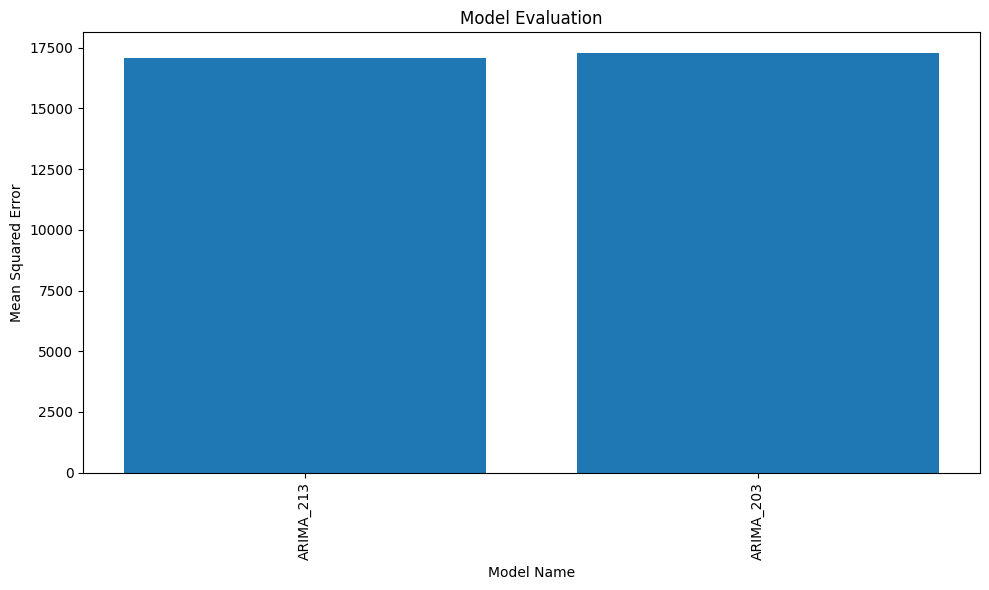

In [161]:
import matplotlib.pyplot as plt

# Sort the results by MSE in ascending order
sorted_results = sorted(results, key=lambda x: x['mse'])

# Extract the model names and MSE values
model_names = [result['model_name'] for result in sorted_results]
mse_values = [result['mse'] for result in sorted_results]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_results)), mse_values)
plt.xticks(range(len(sorted_results)), model_names, rotation='vertical')
plt.xlabel('Model Name')
plt.ylabel('Mean Squared Error')
plt.title('Model Evaluation')
plt.tight_layout()
plt.show()

In [162]:
# Find the model with the smallest MSE
best_model = min(results, key=lambda x: x['mse'])

# Print the best model's detailed information
print("Best Model Information:")
print(f"Model Name: {best_model['model_name']}")

Best Model Information:
Model Name: ARIMA_213


In [163]:
# Reset the index of the predicted values
forecast_df = pd.DataFrame(best_model['predictions']).reset_index(drop=True)

# 'time' is an index in 'test_df'
time_values = test_df.index

# Make sure that the time index aligns correctly
if len(forecast_df) == len(time_values):
    forecast_df.index = time_values

    # Assign the aligned predicted values to the 'best_model_predictions' column in 'test_df'
    test_df['best_model_predictions'] = forecast_df
else:
    print("Length mismatch between time index and predicted values.")

C:\Users\Asus\AppData\Local\Temp\ipykernel_35372\3679438482.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



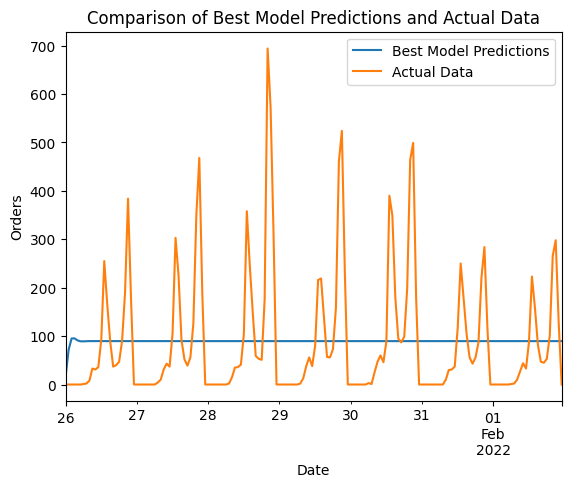

In [164]:
import matplotlib.pyplot as plt

# Plot the predictions of the best model and the orders_winsorized data
test_df['best_model_predictions'].plot(legend=True, label='Best Model Predictions')
test_df['orders'].plot(legend=True, label='Actual Data')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Comparison of Best Model Predictions and Actual Data')
plt.legend()
plt.show()

# SARIMA

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define the ARIMA models to try
sarimax_orders = [((1, 0, 1), (1, 0, 1, 168))]
results = []

# Iterate over the ARIMA orders
for order in sarimax_orders:
    # Fit an ARIMA model on the training data
    model = SARIMAX(train_df['orders'], order=order[0], seasonal_order=order[1])
    model_fit = model.fit()

    # Predict next week's orders using the SARIMA model
    start_date = test_df.index.min()
    end_date = test_df.index.max()
    pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')
    
    # Evaluate model performance on the testing data
    mse = mean_squared_error(test_df['orders'], pred)
    r2 = r2_score(test_df['orders'], pred)

    # Create a dictionary to store the results
    result = {
        'model_name': f"ARIMA_{order[0]}{order[1]}",
        'predictions': pred,
        'mse': mse,
        'r2': r2
    }
    results.append(result)

    # Print the evaluation metrics
    print(f"ARIMA({order[0]}, {order[1]}")
    print("MSE:", mse)
    print("R-squared:", r2)
    print()

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\stat

ARIMA((1, 0, 1), (1, 0, 1, 168)
MSE: 483.44455145938093
R-squared: 0.9717622782541295



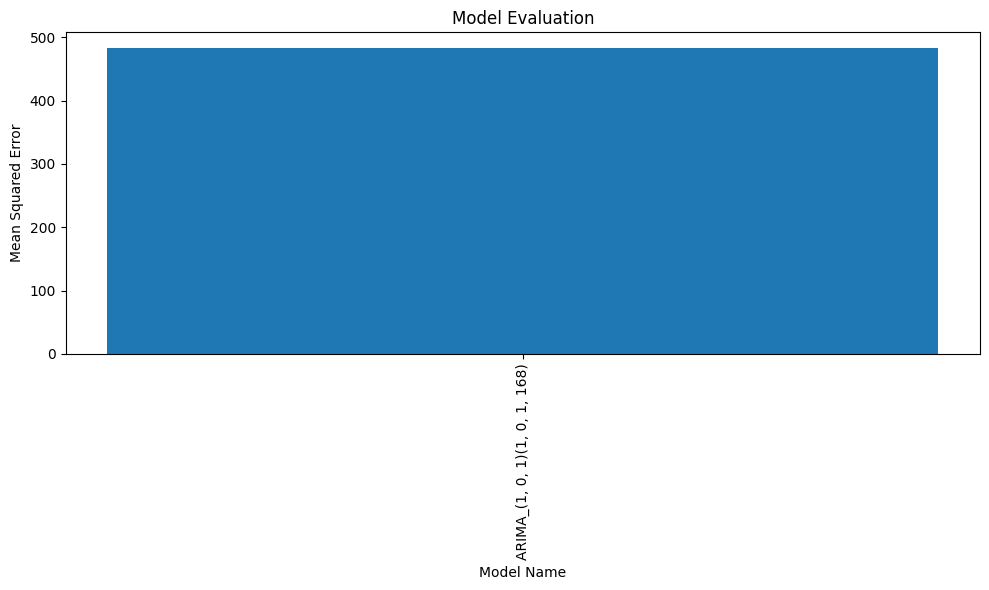

In [166]:
import matplotlib.pyplot as plt

# Sort the results by MSE in ascending order
sorted_results = sorted(results, key=lambda x: x['mse'])

# Extract the model names and MSE values
model_names = [result['model_name'] for result in sorted_results]
mse_values = [result['mse'] for result in sorted_results]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_results)), mse_values)
plt.xticks(range(len(sorted_results)), model_names, rotation='vertical')
plt.xlabel('Model Name')
plt.ylabel('Mean Squared Error')
plt.title('Model Evaluation')
plt.tight_layout()
plt.show()

In [167]:
# Find the model with the smallest MSE
best_model = min(results, key=lambda x: x['mse'])

# Print the best model's detailed information
print("Best Model Information:")
print(f"Model Name: {best_model['model_name']}")

Best Model Information:
Model Name: ARIMA_(1, 0, 1)(1, 0, 1, 168)


In [168]:
# Reset the index of the predicted values
forecast_df = pd.DataFrame(best_model['predictions']).reset_index(drop=True)

# 'time' is an index in 'test_df'
time_values = test_df.index

# Make sure that the time index aligns correctly
if len(forecast_df) == len(time_values):
    forecast_df.index = time_values

    # Assign the aligned predicted values to the 'best_model_predictions' column in 'test_df'
    test_df['best_model_predictions'] = forecast_df
else:
    print("Length mismatch between time index and predicted values.")

C:\Users\Asus\AppData\Local\Temp\ipykernel_35372\3679438482.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



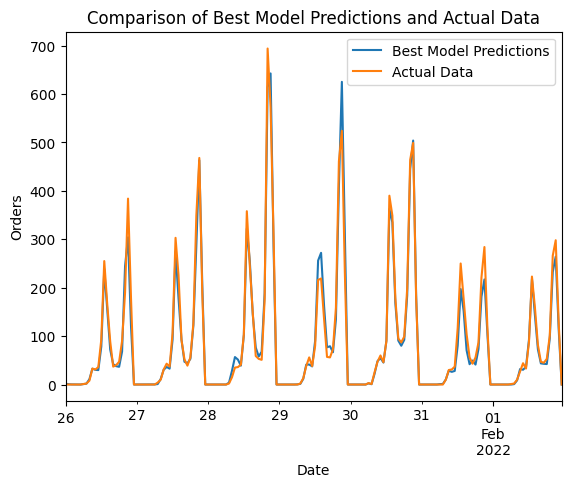

In [169]:
import matplotlib.pyplot as plt

# Plot the predictions of the best model and the orders_winsorized data
test_df['best_model_predictions'].plot(legend=True, label='Best Model Predictions')
test_df['orders'].plot(legend=True, label='Actual Data')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Comparison of Best Model Predictions and Actual Data')
plt.legend()
plt.show()